# MACHINE LEARNING — ASSIGNMENT 2 (Template)

**Topic:** Multi-model classification + Streamlit deployment  
**Planned Dataset:** Credit Card Default (UCI/Kaggle)

> Use this notebook as your *single source of truth* while developing.  
> Later, you can copy core code into `model/` scripts and your `app.py`.

---


## STUDENT INFORMATION (REQUIRED — DO NOT DELETE)

Fill these before submission.

- **Name:** HARISH BHATT  
- **StudentID:** 2025AA05578@wilp.bits-pilani.ac.in
- **Program:** M.Tech (AIML/DSE)  
- **Course:** Machine Learning  
- **Assignment:** 2  
- **Submission Date:** 15-Feb-2026  


## 1) Dataset Selection, Loading & Metadata

In [1]:
# REQUIRED: Fill these metadata fields (used later in README)
DATASET_NAME = "Default of Credit Card Clients"
DATASET_SOURCE = "UCI / Kaggle"   # paste the exact URL in README
TARGET_COL = "default payment next month"  # confirm exact column name in your file

# Path to dataset file
DATA_PATH = "https://github.com/Harishbhatt07/ML-Assignment-2/blob/main/notebooks/data/UCI_Credit_Card.csv"

print("DATASET METADATA")
print("Name   :", DATASET_NAME)
print("Source :", DATASET_SOURCE)
print("Target :", TARGET_COL)
print("Path   :", DATA_PATH)


DATASET METADATA
Name   : Default of Credit Card Clients
Source : UCI / Kaggle
Target : default payment next month
Path   : https://github.com/Harishbhatt07/ML-Assignment-2/blob/main/notebooks/data/UCI_Credit_Card.csv


## 1) Imports & Environment Check

In [2]:
# If running in Colab, uncomment and install dependencies as needed
!pip -q install pandas numpy scikit-learn xgboost matplotlib seaborn joblib

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    precision_score, recall_score,
    f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)


Python: 3.12.12
pandas: 2.2.2


## 2) Load Dataset

In [3]:
import pandas as pd

DATA_PATH = "https://raw.githubusercontent.com/Harishbhatt07/ML-Assignment-2/main/model/data/UCI_Credit_Card.csv"

df = pd.read_csv(DATA_PATH)

print(df.shape)

(30000, 25)


In [4]:
# Sanity checks (REQUIRED)
MIN_ROWS = 500
MIN_FEATURES = 12

print("Columns:", len(df.columns))
print("Rows   :", len(df))

# Basic shape checks per assignment requirement
assert len(df) >= MIN_ROWS, f"Dataset has {len(df)} rows; need at least {MIN_ROWS}."
# features check will be done after defining X (excluding target)


Columns: 25
Rows   : 30000


## 3) Quick EDA / Data Checks (Optional but useful)

In [5]:
# Basic info
display(df.describe(include='all').T.head(30))
print("\nMissing values per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

# Class balance (update target column name if needed)
TARGET_COL = "default payment next month"  # <-- confirm exact name
if TARGET_COL in df.columns:
    display(df[TARGET_COL].value_counts(dropna=False))
else:
    print(f"Target column '{TARGET_COL}' not found. Columns are:", list(df.columns))


,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0



Missing values per column (top 20):


,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


Target column 'default payment next month' not found. Columns are: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


## 4) Preprocessing

In [6]:
# 4.1 Drop ID column if present
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# 4.2 Define X and y
TARGET_COL = "default.payment.next.month"  # <-- confirm exact name
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (30000, 23) | y shape: (30000,)


In [7]:
# Feature/target sanity checks (REQUIRED)

assert TARGET_COL in df.columns, f"Target column not found: {TARGET_COL}"

n_features = X.shape[1]
print("Number of features (X):", n_features)

assert n_features >= MIN_FEATURES, f"Dataset has {n_features} features; need at least {MIN_FEATURES}."

# Target distribution (useful for observations)
print("\nTarget distribution:")
display(y.value_counts(normalize=True))


Number of features (X): 23

Target distribution:


,proportion
default.payment.next.month,
0,0.7788
1,0.2212


## 5) Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (24000, 23) Test: (6000, 23)


## 6) Scaling (for Logistic Regression + KNN; optional for others)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaled shapes: (24000, 23) (6000, 23)


## 7) Evaluation Utilities

In [10]:
def get_binary_proba(model, X):
    """Return P(class=1) for binary classifiers."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        # Convert decision scores to pseudo-probabilities via min-max scaling as fallback
        scores = model.decision_function(X)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")
    return proba


def evaluate_model(model, Xtr, Xte, ytr, yte, label_name=None):
    """Fit, predict, compute required metrics for binary classification."""
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_prob = get_binary_proba(model, Xte)

    metrics = {
        "Accuracy": accuracy_score(yte, y_pred),
        "AUC": roc_auc_score(yte, y_prob),
        "Precision": precision_score(yte, y_pred, zero_division=0),
        "Recall": recall_score(yte, y_pred, zero_division=0),
        "F1": f1_score(yte, y_pred, zero_division=0),
        "MCC": matthews_corrcoef(yte, y_pred),
    }

    # Confusion matrix + report
    cm = confusion_matrix(yte, y_pred)
    report = classification_report(yte, y_pred, digits=4, zero_division=0)

    return metrics, cm, report


## 8) Train the 6 Required Models

In [11]:
results = []
artifacts = {}  # store models + cm/report for later use in Streamlit

# 8.1 Logistic Regression (scaled)
lr = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
m, cm, report = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("Logistic Regression", m))
artifacts["Logistic Regression"] = {"model": lr, "cm": cm, "report": report}

# 8.2 Decision Tree (unscaled)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
m, cm, report = evaluate_model(dt, X_train, X_test, y_train, y_test)
results.append(("Decision Tree", m))
artifacts["Decision Tree"] = {"model": dt, "cm": cm, "report": report}

# 8.3 KNN (scaled)
knn = KNeighborsClassifier(n_neighbors=5)
m, cm, report = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("KNN", m))
artifacts["KNN"] = {"model": knn, "cm": cm, "report": report}

# 8.4 Naive Bayes (scaled is fine)
nb_model = GaussianNB()
m, cm, report = evaluate_model(nb_model, X_train_scaled, X_test_scaled, y_train, y_test)
results.append(("Naive Bayes (Gaussian)", m))
artifacts["Naive Bayes (Gaussian)"] = {"model": nb_model, "cm": cm, "report": report}

# 8.5 Random Forest (unscaled)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
m, cm, report = evaluate_model(rf, X_train, X_test, y_train, y_test)
results.append(("Random Forest", m))
artifacts["Random Forest"] = {"model": rf, "cm": cm, "report": report}

# 8.6 XGBoost (unscaled)
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    n_jobs=-1
)
m, cm, report = evaluate_model(xgb, X_train, X_test, y_train, y_test)
results.append(("XGBoost", m))
artifacts["XGBoost"] = {"model": xgb, "cm": cm, "report": report}

results_df = pd.DataFrame([r[1] for r in results], index=[r[0] for r in results])
display(results_df)


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.807667,0.707636,0.686825,0.239638,0.355307,0.324443
Decision Tree,0.714500,0.607451,0.369418,0.411454,0.389305,0.204216
KNN,0.792833,0.701435,0.548724,0.356443,0.432161,0.323267
Naive Bayes (Gaussian),0.752500,0.724930,0.451474,0.553881,0.497462,0.338620
Random Forest,0.813500,0.754821,0.636842,0.364732,0.463824,0.381429
XGBoost,0.816667,0.777358,0.655267,0.360965,0.465500,0.389585


In [12]:
# Results validation (REQUIRED — prevent accidental 0.0 / missing metrics)

REQUIRED_MODELS = [
    "Logistic Regression",
    "Decision Tree",
    "KNN",
    "Naive Bayes (Gaussian)",
    "Random Forest",
    "XGBoost"
]

# Check all required models present
missing = [m for m in REQUIRED_MODELS if m not in results_df.index]
assert not missing, f"Missing model results for: {missing}"

# Check for NaNs
assert not results_df.isna().any().any(), "Some metrics are NaN. Check AUC/probabilities."

# Check metrics not all zeros
for col in results_df.columns:
    assert (results_df[col] != 0).any(), f"Column {col} looks all zeros — did metrics compute correctly?"

print("✅ Results table contains all required models and valid metric values.")
display(results_df)


✅ Results table contains all required models and valid metric values.


,Accuracy,AUC,Precision,Recall,F1,MCC
Logistic Regression,0.807667,0.707636,0.686825,0.239638,0.355307,0.324443
Decision Tree,0.714500,0.607451,0.369418,0.411454,0.389305,0.204216
KNN,0.792833,0.701435,0.548724,0.356443,0.432161,0.323267
Naive Bayes (Gaussian),0.752500,0.724930,0.451474,0.553881,0.497462,0.338620
Random Forest,0.813500,0.754821,0.636842,0.364732,0.463824,0.381429
XGBoost,0.816667,0.777358,0.655267,0.360965,0.465500,0.389585


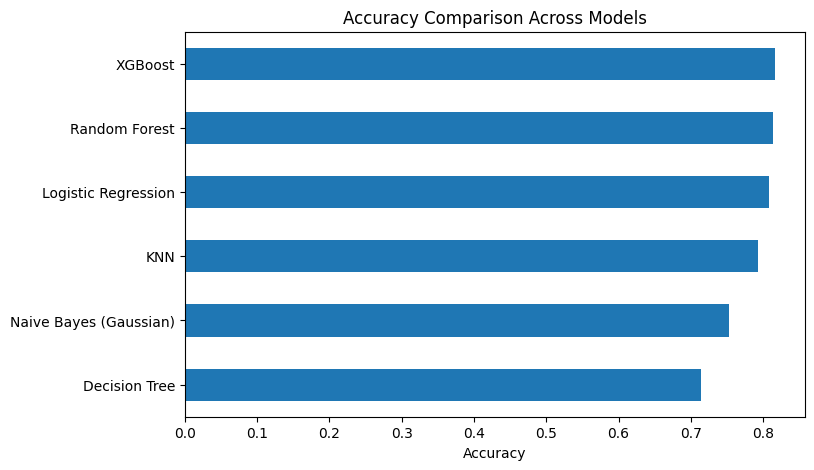

In [13]:
# Bar Plot — Accuracy Comparison
plt.figure(figsize=(8,5))
results_df["Accuracy"].sort_values().plot(kind="barh")
plt.title("Accuracy Comparison Across Models")
plt.xlabel("Accuracy")
plt.show()

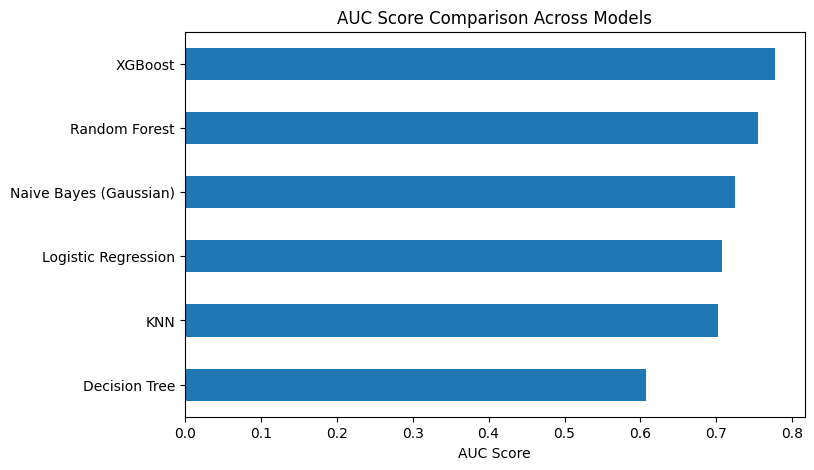

In [14]:
#Bar Plot — AUC Comparison
plt.figure(figsize=(8,5))
results_df["AUC"].sort_values().plot(kind="barh")
plt.title("AUC Score Comparison Across Models")
plt.xlabel("AUC Score")
plt.show()

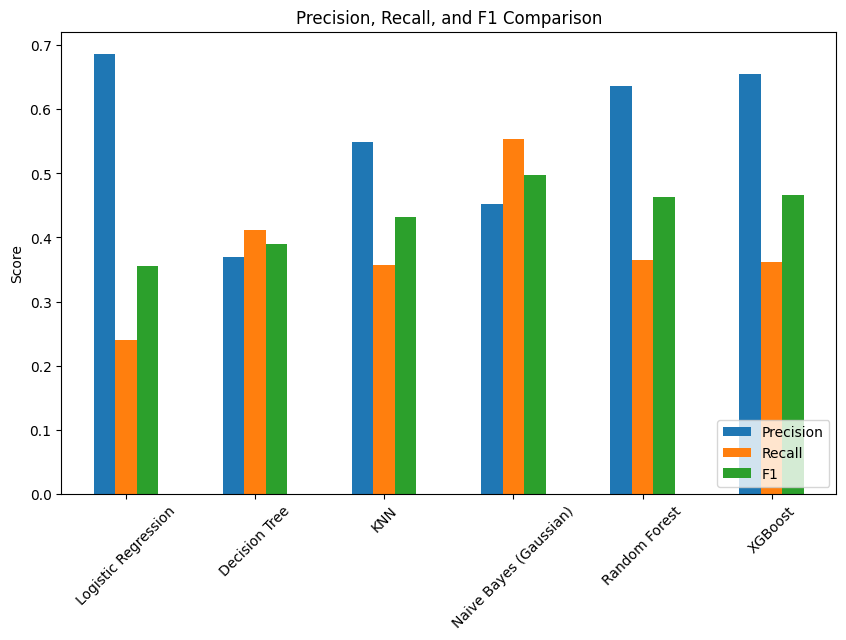

In [15]:
#Grouped Bar Chart — Precision, Recall, F1 Comparison
metrics_to_plot = ["Precision", "Recall", "F1"]

results_df[metrics_to_plot].plot(kind="bar", figsize=(10,6))
plt.title("Precision, Recall, and F1 Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

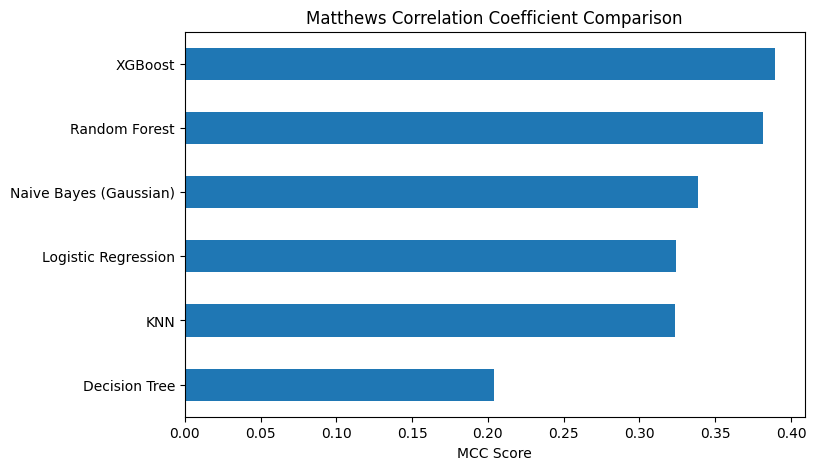

In [16]:
# MCC Comparison Plot (Advanced Metric)
plt.figure(figsize=(8,5))
results_df["MCC"].sort_values().plot(kind="barh")
plt.title("Matthews Correlation Coefficient Comparison")
plt.xlabel("MCC Score")
plt.show()

## 9) Pick a Best Model (Customize your criteria)

In [17]:
# You can choose based on AUC, MCC, or F1. Here we pick best by AUC.
best_model_name = results_df["AUC"].idxmax()
best_model = artifacts[best_model_name]["model"]

print("Best model by AUC:", best_model_name)


Best model by AUC: XGBoost


## 10) Visuals: Confusion Matrix & Report (for selected model)

Classification Report:
               precision    recall  f1-score   support

           0     0.8391    0.9461    0.8894      4673
           1     0.6553    0.3610    0.4655      1327

    accuracy                         0.8167      6000
   macro avg     0.7472    0.6535    0.6774      6000
weighted avg     0.7984    0.8167    0.7956      6000



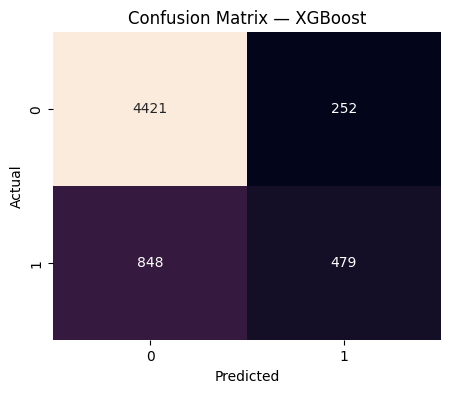

In [18]:
cm = artifacts[best_model_name]["cm"]
report = artifacts[best_model_name]["report"]

print("Classification Report:\n", report)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.show()


## 11) Save Artifacts for Streamlit

In [19]:
# Create folders
os.makedirs("model", exist_ok=True)

# Save scaler (needed for LR + KNN + NB in this notebook)
joblib.dump(scaler, "model/scaler.pkl")

# Save each model separately
for name, obj in artifacts.items():
    safe_name = name.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    joblib.dump(obj["model"], f"model/{safe_name}.pkl")

print("Saved models + scaler into ./model/")


Saved models + scaler into ./model/


## 12) Placeholder: Observations (Write in Markdown)

Create an observation table later for README:

| Model | Observation |
|------|-------------|
| Logistic Regression | ... |
| Decision Tree | ... |
| KNN | ... |
| Naive Bayes | ... |
| Random Forest | ... |
| XGBoost | ... |

Focus on:
- Which performed best and why (AUC/MCC/F1)
- Which underperformed and why (e.g., NB assumptions)
- Impact of scaling on LR/KNN
- Any overfitting signs (Tree vs Ensembles)


## 13) Notes for Streamlit `app.py` (Planning)

Your Streamlit app should:
- Allow user to upload **CSV test data** (include target column so you can compute metrics)
- Allow selecting a model from dropdown
- Load model from `model/*.pkl`
- If model requires scaling: load `scaler.pkl` and transform numeric features before predict
- Show:
  - Metrics (Accuracy, AUC, Precision, Recall, F1, MCC)
  - Confusion matrix or classification report


## 14) Final Submission Checklist (Before you submit)

- [ ] Dataset meets **≥ 500 rows** and **≥ 12 features**
- [ ] All **6 models** trained on the **same dataset**
- [ ] Metrics computed: Accuracy, AUC, Precision, Recall, F1, MCC
- [ ] `results_df` comparison table ready to paste into README
- [ ] Observation table filled (model → observation)
- [ ] Models + scaler saved into `model/`
- [ ] `requirements.txt` created and tested
- [ ] Streamlit app (`app.py`) runs locally without errors
- [ ] Deployed on Streamlit Community Cloud and link works
- [ ] Ran on BITS Virtual Lab and captured **one screenshot**
- [ ] Final PDF created with required order: GitHub link → Streamlit link → screenshot → README content
